# Cell type annotation prediction - Jansky & Westerhout


In this notebook, an [scGPT](https://www.nature.com/articles/s41592-024-02201-0) model is used to predict a cell type annotation with a given gene expression profile.

This follows the tutorial from scGPT [here](https://github.com/bowang-lab/scGPT/blob/main/tutorials/Tutorial_Annotation.ipynb), but instead of fine-tuning the entire model, a smaller neural network is trained, using the embeddings of the gene expressions as inputs, to make a prediction.

The same approach is made with the [Geneformer](https://www.nature.com/articles/s41586-023-06139-9.epdf?sharing_token=u_5LUGVkd3A8zR-f73lU59RgN0jAjWel9jnR3ZoTv0N2UB4yyXENUK50s6uqjXH69sDxh4Z3J4plYCKlVME-W2WSuRiS96vx6t5ex2-krVDS46JkoVvAvJyWtYXIyj74pDWn_DutZq1oAlDaxfvBpUfSKDdBPJ8SKlTId8uT47M%3D) model and the results are compared against each other.

This approach greatly reduces time and complexity.

#TODO: When the number of predicted classes is not equal to the number of true classes, the evaluation metrics calculation can be heavily affected. Need to handle this case.


In [ ]:
#!pip3 install helical
#!conda install -c conda-forge louvain
#!pip3 install datasets --upgrade

In [8]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import anndata as ad
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from scipy.sparse import lil_matrix
import torch.optim as optim
from helical.models.scgpt import scGPT, scGPTConfig
from helical.models.geneformer import Geneformer, GeneformerConfig
from copy import deepcopy
from torch.nn.functional import one_hot
import scanpy as sc
import matplotlib.pyplot as plt

Fine-tuning data: Jansky

In [2]:
# Load fine-tuning data
adata = sc.read_h5ad("jansky_adrenal_medulla.h5ad")


In [3]:
# Seurat to AnnData conversion can be tricky. Ensure that the raw counts are properly assigned. 
print(adata.X)
print(adata.raw.X)

  (0, 17)	1.5715039378205398
  (0, 40)	2.1549854987676813
  (0, 46)	1.5715039378205398
  (0, 47)	1.5715039378205398
  (0, 48)	1.5715039378205398
  (0, 135)	1.5715039378205398
  (0, 143)	1.5715039378205398
  (0, 145)	1.5715039378205398
  (0, 161)	2.9991968979101786
  (0, 184)	2.5210495220503306
  (0, 186)	1.5715039378205398
  (0, 189)	1.5715039378205398
  (0, 215)	1.5715039378205398
  (0, 216)	1.5715039378205398
  (0, 229)	2.1549854987676813
  (0, 251)	2.1549854987676813
  (0, 253)	1.5715039378205398
  (0, 282)	1.5715039378205398
  (0, 289)	2.1549854987676813
  (0, 290)	2.5210495220503306
  (0, 300)	1.5715039378205398
  (0, 301)	1.5715039378205398
  (0, 333)	1.5715039378205398
  (0, 335)	2.788433166553626
  (0, 343)	1.5715039378205398
  :	:
  (10738, 25656)	1.7414976344471669
  (10738, 25678)	1.7414976344471669
  (10738, 25712)	2.342936388517613
  (10738, 25722)	1.7414976344471669
  (10738, 25733)	2.715862740839004
  (10738, 25757)	1.7414976344471669
  (10738, 25758)	1.7414976344471669


In [4]:
# Copy raw counts to adata.X if necessary
adata.X = adata.raw.X.copy()
adata.var["gene_name"] = adata.var_names # "Data must have the provided key 'gene_name' in its 'var' section to be processed by the Helical RNA model."

Randomly choose approx. 20% of patients to leave out for test set (final evaluation).

In [5]:
import random

# unique patient ids
unseen_patients = random.sample(list(set(adata.obs['orig.ident'])), 3)
#unseen_patients = ['14766', '13952', '14164']  # specify patients to leave out for evaluation
#unseen_patients = ['14627', '14742', '14707']  # specify patients to leave out for evaluation
print(unseen_patients)

adata_evaluation = adata[adata.obs["orig.ident"].isin(unseen_patients)]
adata_finetuning  = adata[~adata.obs["orig.ident"].isin(unseen_patients)]


['13363', '15161', '14766']


We are interested in the names of the cells we want to predict. They are saved in `adata.obs["active_ident_celltypes"]`.

Additionally, we need to know how many distinct cell types/classes we have.

In [6]:
adata_finetuning.obs


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,CC.Difference,RNA_snn_res.1,...,DF.classifications_0.25_0.005_501,pANN_0.25_0.23_0,DF.classifications_0.25_0.23_0,pANN_0.25_0.24_1356,DF.classifications_0.25_0.24_1356,pANN_0.25_0.24_1085,DF.classifications_0.25_0.24_1085,RNA_snn_res.5,gland_clusters,active_ident_celltypes
AAACCCACAGCTGAAG_1,14607,2622.0,1735,0.114416,-0.029956,-0.089442,G1,14607,0.059485,15,...,NA,NaN,NA,NaN,NA,NaN,NA,72,1,Bridge
AAACGCTCAGCAGATG_1,14607,1967.0,1271,0.152517,-0.045497,-0.046038,G1,14607,0.000541,15,...,NA,NaN,NA,NaN,NA,NaN,NA,21,1,connecting Chromaffin cells
AAACGCTGTCAAAGTA_1,14607,1984.0,1347,0.201613,0.087886,-0.057184,S,14607,0.145070,19,...,NA,NaN,NA,NaN,NA,NaN,NA,23,2,Neuroblasts
AAACGCTTCACCGACG_1,14607,4516.0,2543,0.088574,0.172065,0.435754,G2M,14607,-0.263690,19,...,NA,NaN,NA,NaN,NA,NaN,NA,65,2,cycling Neuroblasts
AAACGCTTCCTTATCA_1,14607,4277.0,2576,0.023381,0.098847,0.087765,S,14607,0.011081,19,...,NA,NaN,NA,NaN,NA,NaN,NA,65,2,cycling Neuroblasts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTACGTTTCCACGTAA_17,14773,1843.0,1355,1.899078,-0.098486,-0.034321,G1,14773,-0.064164,12,...,NA,0.193362,Singlet,0.194976,Singlet,0.194976,Singlet,23,0,connecting Chromaffin cells
TTCCGGTTCGGTAGGA_17,14773,1853.0,1227,0.269833,0.019770,-0.074358,S,14773,0.094128,19,...,NA,0.323713,Singlet,0.320811,Singlet,0.320811,Singlet,23,2,Neuroblasts
TTGGTTTAGTTGAATG_17,14773,2531.0,1527,0.158040,0.041482,-0.074001,S,14773,0.115483,30,...,NA,0.257816,Singlet,0.258585,Singlet,0.258585,Singlet,47,4,late Chromaffin cells
TTGTGGATCTCGGCTT_17,14773,1643.0,1054,0.304321,-0.027369,-0.064153,G1,14773,0.036784,30,...,NA,0.194565,Singlet,0.195206,Singlet,0.195206,Singlet,47,4,late Chromaffin cells


In [7]:
adata_finetuning.var

,vst.mean,vst.variance,vst.variance.expected,vst.variance.standardized,vst.variable,gene_name
RP11-34P13.7,0.002512,0.002506,0.002643,0.948367,0,RP11-34P13.7
AL627309.1,0.004932,0.004908,0.005316,0.923144,0,AL627309.1
AP006222.2,0.030055,0.030457,0.035064,0.868621,0,AP006222.2
RP4-669L17.10,0.086815,0.089336,0.107894,0.827992,0,RP4-669L17.10
RP5-857K21.15,0.000000,0.000000,0.000000,0.000000,0,RP5-857K21.15
...,...,...,...,...,...,...
CTD-2382H12.2,0.000000,0.000000,0.000000,0.000000,0,CTD-2382H12.2
RP4-737E23.2,0.000000,0.000000,0.000000,0.000000,0,RP4-737E23.2
BPIFB6,0.000000,0.000000,0.000000,0.000000,0,BPIFB6
RLN3,0.000000,0.000000,0.000000,0.000000,0,RLN3


  .apply(lambda df: df.assign(freq=df["count"] / df["count"].sum()))



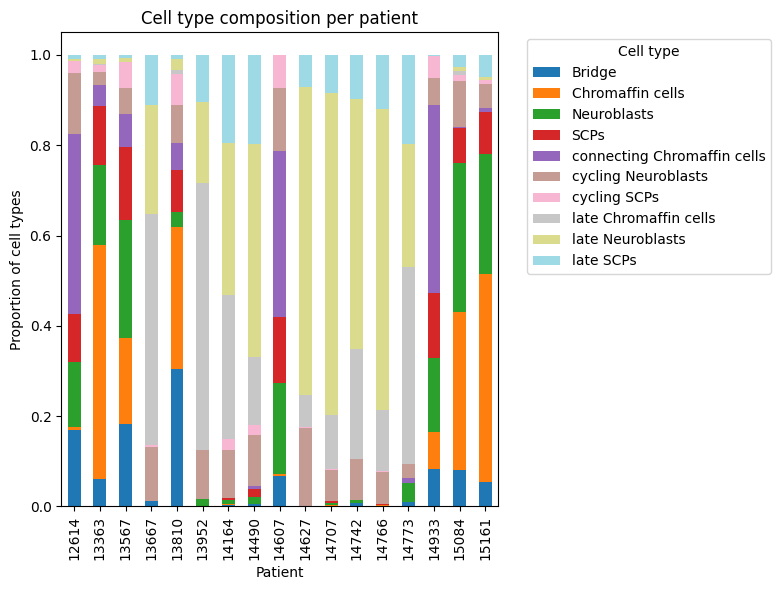

In [9]:
# 
celltype_counts = (
    adata.obs
    .groupby(["orig.ident", "active_ident_celltypes"])
    .size()
    .reset_index(name="count")
)
celltype_freq = (
    celltype_counts
    .groupby("orig.ident")
    .apply(lambda df: df.assign(freq=df["count"] / df["count"].sum()))
    .reset_index(drop=True)
)
# print(celltype_freq)

# pivot to have patients as rows and cell types as columns (proportions)
celltype_pivot = celltype_freq.pivot(index="orig.ident", 
                                     columns="active_ident_celltypes", 
                                     values="freq").fillna(0)

# stacked bar plot
celltype_pivot.plot(kind="bar", 
                    stacked=True, 
                    figsize=(8,6), 
                    colormap="tab20")  # nice color palette

plt.ylabel("Proportion of cell types")
plt.xlabel("Patient")
plt.title("Cell type composition per patient")
plt.legend(title="Cell type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [10]:
# get labels: the celltype
num_types = adata_finetuning.obs["active_ident_celltypes"].unique().shape[0]
id2type = dict(enumerate(adata_finetuning.obs["active_ident_celltypes"].astype("category").cat.categories))

celltypes_labels = np.array(adata_finetuning.obs["active_ident_celltypes"].tolist())

This is all summarized in this dictionary:

In [11]:
id2type

{0: 'Bridge',
 1: 'Chromaffin cells',
 2: 'Neuroblasts',
 3: 'SCPs',
 4: 'connecting Chromaffin cells',
 5: 'cycling Neuroblasts',
 6: 'cycling SCPs',
 7: 'late Chromaffin cells',
 8: 'late Neuroblasts',
 9: 'late SCPs'}

Use the Helical package to get the embeddings of the gene expression profile.

The only thing we need to specify is the column containing the names of the genes. (`gene_name` in this case)

The resulting embeddings are the input features `x` for our smaller NN model.

# scGPT

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Configure and initialize the scGPT model
scgpt_config = scGPTConfig(batch_size=50, device=device)
scgpt = scGPT(configurer = scgpt_config)

# Process the data for the scGPT model
Normalize_SubsetHighlyVariable = False # This logic is also connected to processing the left out data (adata_unseen).

if Normalize_SubsetHighlyVariable:
    data_processed = scgpt.process_data(adata_finetuning, gene_names = "gene_name", fine_tuning=True)
else:
    data_processed = scgpt.process_data(adata_finetuning, gene_names = "gene_name")

# Get embeddings
x_scgpt = scgpt.get_embeddings(data_processed)
x_scgpt.shape

  warnings.warn(

INFO:helical.models.scgpt.model:Model finished initializing.
INFO:helical.models.scgpt.model:'scGPT' model is in 'eval' mode, on device 'cuda' with embedding mode 'cell'.
INFO:helical.models.scgpt.model:Processing data for scGPT.
  adata.obs["total_counts"] = adata.X.sum(axis=1)

INFO:helical.models.scgpt.model:Filtering out 4506 genes to a total of 23916 genes with an ID in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.
INFO:helical.models.scgpt.model:Started getting embeddings:
  torch.cuda.amp.autocast(enabled=True),

Embedding cells: 100%|██████████| 163/163 [01:10<00:00,  2.31it/s]
INFO:helical.models.scgpt.model:Finished getting embeddings.


(8103, 512)

With the input features, we also need the corresponding labels `y`.

They correspond to the cell type labels.

As we have a categorical prediction, we transform the cell type labels to integer labels to work with CrossEntropyLoss later.

In [14]:
y = celltypes_labels

encoder = LabelEncoder()
y_encoded_intermediate = encoder.fit_transform(y)
y_encoded = one_hot(torch.tensor(y_encoded_intermediate),num_types).float()

In [15]:
freq = pd.Series(y).value_counts()
freq

late Neuroblasts               1493
connecting Chromaffin cells    1441
Neuroblasts                    1034
cycling Neuroblasts             934
late Chromaffin cells           838
SCPs                            615
Bridge                          510
Chromaffin cells                494
late SCPs                       482
cycling SCPs                    262
Name: count, dtype: int64

## Define and train the model

In [16]:
input_shape = 512

# Define the model architecture
head_model = nn.Sequential(
    nn.Linear(input_shape, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(32, num_types)
    )

print(head_model)

Sequential(
  (0): Linear(in_features=512, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=128, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=32, out_features=10, bias=True)
)


In [17]:
def train_model(model: nn.Sequential,
                X_train: torch.Tensor,
                y_train: torch.Tensor,
                X_val: torch.Tensor,
                y_val: torch.Tensor,
                optimizer = optim.Adam,
                loss_fn = nn.CrossEntropyLoss(),
                num_epochs = 50,
                batch = 64):

    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

    # Validation dataset
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    # Ensure model is in training mode
    model.train()

    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_X)

            # Compute loss
            loss = loss_fn(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase (optional)
        model.eval()
        with torch.no_grad():
            val_losses = []
            for val_X, val_y in val_loader:
                val_outputs = model(val_X)
                val_loss = loss_fn(val_outputs, val_y)
                val_losses.append(val_loss.item())

            print(f"Epoch {epoch+1}, Validation Loss: {sum(val_losses)/len(val_losses)}")

        # Set back to training mode for next epoch
        model.train()

    model.eval()
    return model

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x_scgpt, y_encoded, test_size=0.1, random_state=42)

head_model_scgpt = deepcopy(head_model)
head_model_scgpt = train_model(head_model_scgpt,
                               torch.from_numpy(X_train),
                               y_train,
                               torch.from_numpy(X_test),
                               y_test,
                               optim.Adam(head_model_scgpt.parameters(), lr=0.001),
                               nn.CrossEntropyLoss())

Epoch 1, Validation Loss: 2.010692312167241
Epoch 2, Validation Loss: 1.6366239694448619
Epoch 3, Validation Loss: 1.4032621108568633
Epoch 4, Validation Loss: 1.2142467773877657
Epoch 5, Validation Loss: 1.0587728665425227
Epoch 6, Validation Loss: 0.9626044310056247
Epoch 7, Validation Loss: 0.8913768438192514
Epoch 8, Validation Loss: 0.8308787529285138
Epoch 9, Validation Loss: 0.7940015013401325
Epoch 10, Validation Loss: 0.7584062081116897
Epoch 11, Validation Loss: 0.7376697246844952
Epoch 12, Validation Loss: 0.7031197593762324
Epoch 13, Validation Loss: 0.6847648437206562
Epoch 14, Validation Loss: 0.6535493869047898
Epoch 15, Validation Loss: 0.6435095163492056
Epoch 16, Validation Loss: 0.6139571254069989
Epoch 17, Validation Loss: 0.6022595992455115
Epoch 18, Validation Loss: 0.5897239882212418
Epoch 19, Validation Loss: 0.5888341779892261
Epoch 20, Validation Loss: 0.576568277982565
Epoch 21, Validation Loss: 0.5670520961284637
Epoch 22, Validation Loss: 0.5568630787042471

In [20]:
# Predictions on the test set and ground truth
predictions_nn = head_model_scgpt(torch.Tensor(X_test))
y_pred = np.array(torch.argmax(predictions_nn, dim=1))
y_true = np.array(y_test.argmax(axis=1))

## Present the results
- on the test set and,
- a separate, unseen evaluation set

In [26]:
def get_evaluations(name_data_set, y_true, y_pred) -> dict:
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  print(f"{name_data_set} accuracy: {(accuracy*100):.1f}%")
  print(f"{name_data_set} precision: {(precision*100):.1f}%")
  print(f"{name_data_set} f1: {(f1*100):.1f}%")
  print(f"{name_data_set} recall: {(recall*100):.1f}%")
  return {
      "accuracy": accuracy,
      "precision": precision,
      "f1": f1,
      "recall": recall,
  }

In [27]:
get_evaluations("Test set", y_true, y_pred)

Test set accuracy: 83.7%
Test set precision: 84.0%
Test set f1: 83.3%
Test set recall: 82.8%


{'accuracy': 0.8372379778051788,
 'precision': 0.8401110329945156,
 'f1': 0.8326819940116366,
 'recall': 0.8280502250999456}

In [23]:
y_encoded

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

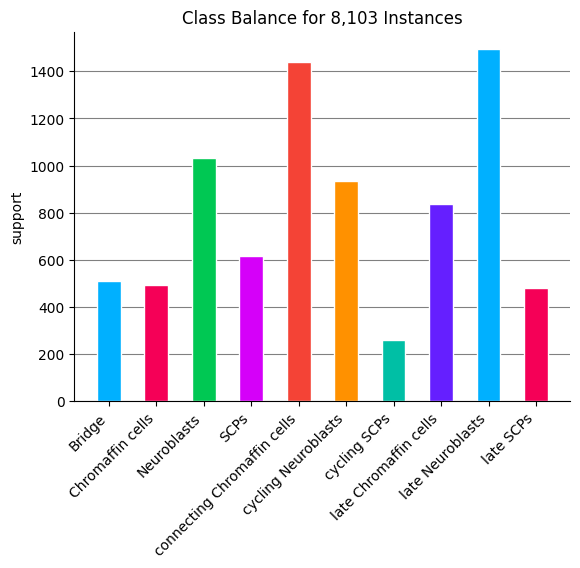

{0: 'Bridge', 1: 'Chromaffin cells', 2: 'Neuroblasts', 3: 'SCPs', 4: 'connecting Chromaffin cells', 5: 'cycling Neuroblasts', 6: 'cycling SCPs', 7: 'late Chromaffin cells', 8: 'late Neuroblasts', 9: 'late SCPs'}


In [ ]:
# Visualize class distribution - Training set
from sklearn_evaluation import plot

ax = plot.target_analysis(y)

# Rotate x-axis tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

plt.show()
print(id2type)

Load the unseen evaluation set. Two options:

1. Evaluation: Load the left out evaluation set from the finetuning dataset. (with true labels - Jansky)
2. Target: Load the dataset that the predictions will be made on. (no true labels - Westerhout)

In [28]:
final_task = "evaluation" # "evaluation" or "target"

target_h5ad_fname = "chayenne_scRNAseq.h5ad" # only used if final_task is "target"
target_anndataobs_preds_fname = target_h5ad_fname.split(".h5ad")[0] + "_celltype_preds.csv" # only used if final_task is "target"

if final_task == "target":
    adata_unseen = sc.read_h5ad(target_h5ad_fname)
    adata_unseen.X = adata_unseen.raw.X.copy()
    adata_unseen.var["gene_name"] = adata_unseen.var_names # "Data must have the provided key 'gene_name' in its 'var' section to be processed by the Helical RNA model."

elif final_task == "evaluation": 
    adata_unseen = adata_evaluation # AnnData preprocessing was done before the finetuning - evaluation split.
    

In [29]:
# Process the unseen data
if Normalize_SubsetHighlyVariable:
    data_processed = scgpt.process_data(adata_unseen, gene_names = "gene_name", fine_tuning=True)
else:
    data_processed = scgpt.process_data(adata_unseen, gene_names = "gene_name")

# Get embeddings and predictions
x_unseen = scgpt.get_embeddings(data_processed)
predictions_nn_unseen = head_model_scgpt(torch.Tensor(x_unseen))

INFO:helical.models.scgpt.model:Processing data for scGPT.
  adata.obs["total_counts"] = adata.X.sum(axis=1)

INFO:helical.models.scgpt.model:Filtering out 4506 genes to a total of 23916 genes with an ID in the scGPT vocabulary.
INFO:helical.models.scgpt.model:Successfully processed the data for scGPT.
INFO:helical.models.scgpt.model:Started getting embeddings:
  torch.cuda.amp.autocast(enabled=True),

Embedding cells: 100%|██████████| 53/53 [00:23<00:00,  2.29it/s]
INFO:helical.models.scgpt.model:Finished getting embeddings.


Unseen evaluation set accuracy: 85.1%
Unseen evaluation set precision: 75.8%
Unseen evaluation set f1: 76.4%
Unseen evaluation set recall: 79.1%


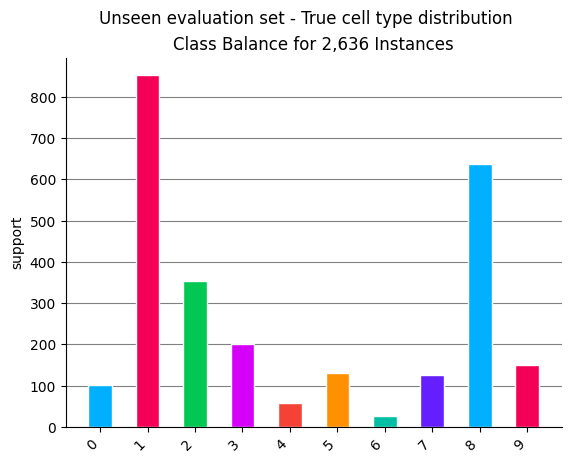

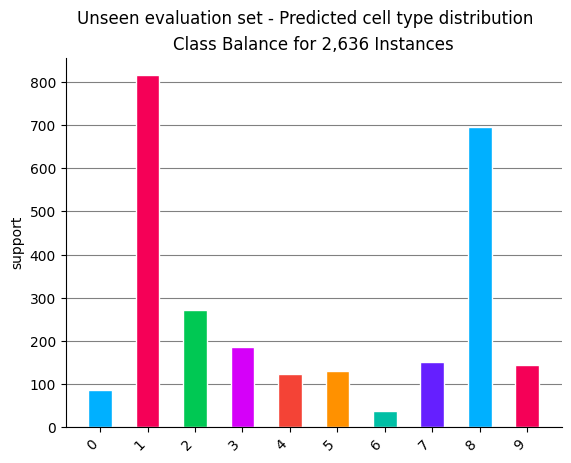

In [35]:
if final_task == "evaluation":
    y_pred_unseen = np.array(torch.argmax(predictions_nn_unseen, dim=1))
    y_true_unseen = np.array(adata_unseen.obs["active_ident_celltypes"].astype("category").cat.codes)
    get_evaluations("Unseen evaluation set", y_true_unseen, y_pred_unseen)

    #Plot class distribution - Unseen evaluation set
    ax = plot.target_analysis(y_true_unseen)
    # Rotate x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.suptitle("Unseen evaluation set - True cell type distribution")
    plt.show()
    
elif final_task == "target":
    y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen, dim=1))]

    save_annData_with_predictions = False
    if save_annData_with_predictions:
        adata_unseen.obs["cell_type_predictions"] = y_pred_unseen
        adata_unseen.obs.to_csv(target_anndataobs_preds_fname)

# Visualize class distribution - Predicted cell types for target data
ax = plot.target_analysis(y_pred_unseen)
# Rotate x-axis tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.suptitle("Unseen evaluation set - Predicted cell type distribution")
plt.show()


We should double check that the cell types are mapped to the correct id numbers for both the training data and this new data set.

In [36]:
if final_task == "evaluation":
    num_types = adata_unseen.obs["active_ident_celltypes"].unique().shape[0]
    id2type_unseen = dict(enumerate(adata_unseen.obs["active_ident_celltypes"].astype("category").cat.categories))
    print(id2type_unseen == id2type)

True


In [42]:
if final_task == "evaluation":
    y_true_unseen = np.array(adata_unseen.obs["active_ident_celltypes"].tolist())
    y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen, dim=1))]

    scgpt_results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

Evaluation set accuracy: 85.1%
Evaluation set precision: 75.8%
Evaluation set f1: 76.4%
Evaluation set recall: 79.1%


In [43]:
print(id2type_unseen)

{0: 'Bridge', 1: 'Chromaffin cells', 2: 'Neuroblasts', 3: 'SCPs', 4: 'connecting Chromaffin cells', 5: 'cycling Neuroblasts', 6: 'cycling SCPs', 7: 'late Chromaffin cells', 8: 'late Neuroblasts', 9: 'late SCPs'}


Plot a confusion matrix to visualise the classification performance for each the cell type. This is done for the evalation set.

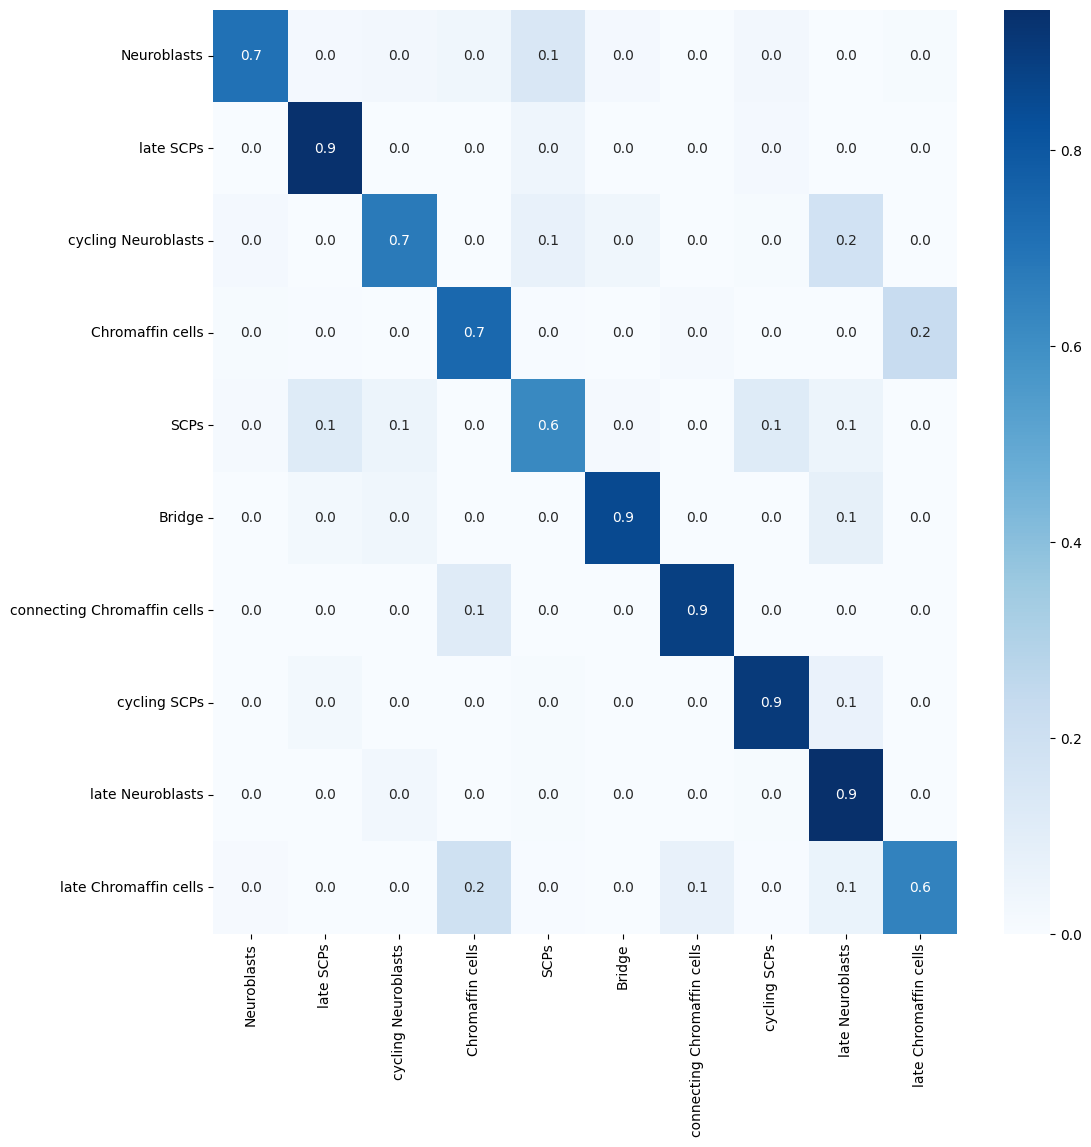

In [44]:
if final_task == "evaluation":
    from sklearn.metrics import confusion_matrix
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    set_predicted_cell_types = list(adata_unseen.obs["active_ident_celltypes"].unique())
    for i in set(y_pred_unseen):
        if i not in set_predicted_cell_types:
            set_predicted_cell_types.remove(i)

    cm = confusion_matrix(y_true_unseen, y_pred_unseen)
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cm = pd.DataFrame(cm, index=set_predicted_cell_types[:cm.shape[0]], columns=set_predicted_cell_types[:cm.shape[1]])
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")

# Geneformer

Let's do the same with the Geneformer.

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if 'rows' in adata.obs:
    adata_finetuning.obs['rows'] = adata_finetuning.obs['rows'].astype(str)
geneformer_config = GeneformerConfig(batch_size=50, device=device)
geneformer = Geneformer(configurer = geneformer_config)

data_geneformer = geneformer.process_data(adata_finetuning, gene_names = "gene_name")
x_geneformer = geneformer.get_embeddings(data_geneformer)
x_geneformer.shape

INFO:helical.models.geneformer.model:Model finished initializing.
INFO:helical.models.geneformer.model:'gf-12L-38M-i4096' model is in 'eval' mode, on device 'cuda' with embedding mode 'cell'.
INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/sarper_unix/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/sarper_unix/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/sarper_unix/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 17555 genes to Ensembl IDs from a total of 28422 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 8024 × 28422
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.

(8024, 512)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(x_geneformer, y_encoded, test_size=0.1, random_state=42)

head_model_geneformer = deepcopy(head_model)
head_model_geneformer = train_model(head_model_geneformer,
                                    torch.tensor(X_train),
                                    y_train,
                                    torch.tensor(X_test),
                                    y_test,
                                    optim.Adam(head_model_geneformer.parameters(), lr=0.001),
                                    nn.CrossEntropyLoss())

Epoch 1, Validation Loss: 1.1014015491192157
Epoch 2, Validation Loss: 0.6333962816458482
Epoch 3, Validation Loss: 0.4886948512150691
Epoch 4, Validation Loss: 0.42000423257167524
Epoch 5, Validation Loss: 0.4195136519578787
Epoch 6, Validation Loss: 0.386587156699254
Epoch 7, Validation Loss: 0.3638423681259155
Epoch 8, Validation Loss: 0.36238491993684036
Epoch 9, Validation Loss: 0.3416837728940524
Epoch 10, Validation Loss: 0.34537209341159236
Epoch 11, Validation Loss: 0.33101881123506105
Epoch 12, Validation Loss: 0.32591029887016004
Epoch 13, Validation Loss: 0.3346465229988098
Epoch 14, Validation Loss: 0.3153350674189054
Epoch 15, Validation Loss: 0.31784011882085067
Epoch 16, Validation Loss: 0.3035476127496132
Epoch 17, Validation Loss: 0.3121848782667747
Epoch 18, Validation Loss: 0.2905778896350127
Epoch 19, Validation Loss: 0.30400814574498397
Epoch 20, Validation Loss: 0.3133898251331769
Epoch 21, Validation Loss: 0.3093366130040242
Epoch 22, Validation Loss: 0.29343259

In [32]:
data_unseen_geneformer = geneformer.process_data(adata_unseen, gene_names = "gene_name")
x_unseen_geneformer = geneformer.get_embeddings(data_unseen_geneformer)
predictions_nn_unseen_geneformer = head_model_geneformer(torch.Tensor(x_unseen_geneformer))

INFO:helical.models.geneformer.model:Processing data for Geneformer.
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/sarper_unix/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/sarper_unix/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/sarper_unix/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.pep.all.fa.gz.pickle
INFO:helical.utils.mapping:Mapped 17555 genes to Ensembl IDs from a total of 28422 genes.
INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 2715 × 28422
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'RNA_snn_res.1', 'seurat_clusters', 'pANN_0.25_0.26_905', 'DF.classifications_0.25_0.26_905', 'pANN_0.25_0.26_1131', 'DF.classifications_0.25_0.2

In [38]:
y_true_unseen = np.array(adata_unseen.obs["LVL1"].tolist())
y_pred_unseen = [id2type[prediction] for prediction in np.array(torch.argmax(predictions_nn_unseen_geneformer, dim=1))]

geneformer_results = get_evaluations("Evaluation set", y_true_unseen, y_pred_unseen)

Evaluation set accuracy: 99.2%
Evaluation set precision: 89.5%
Evaluation set f1: 84.1%
Evaluation set recall: 82.0%


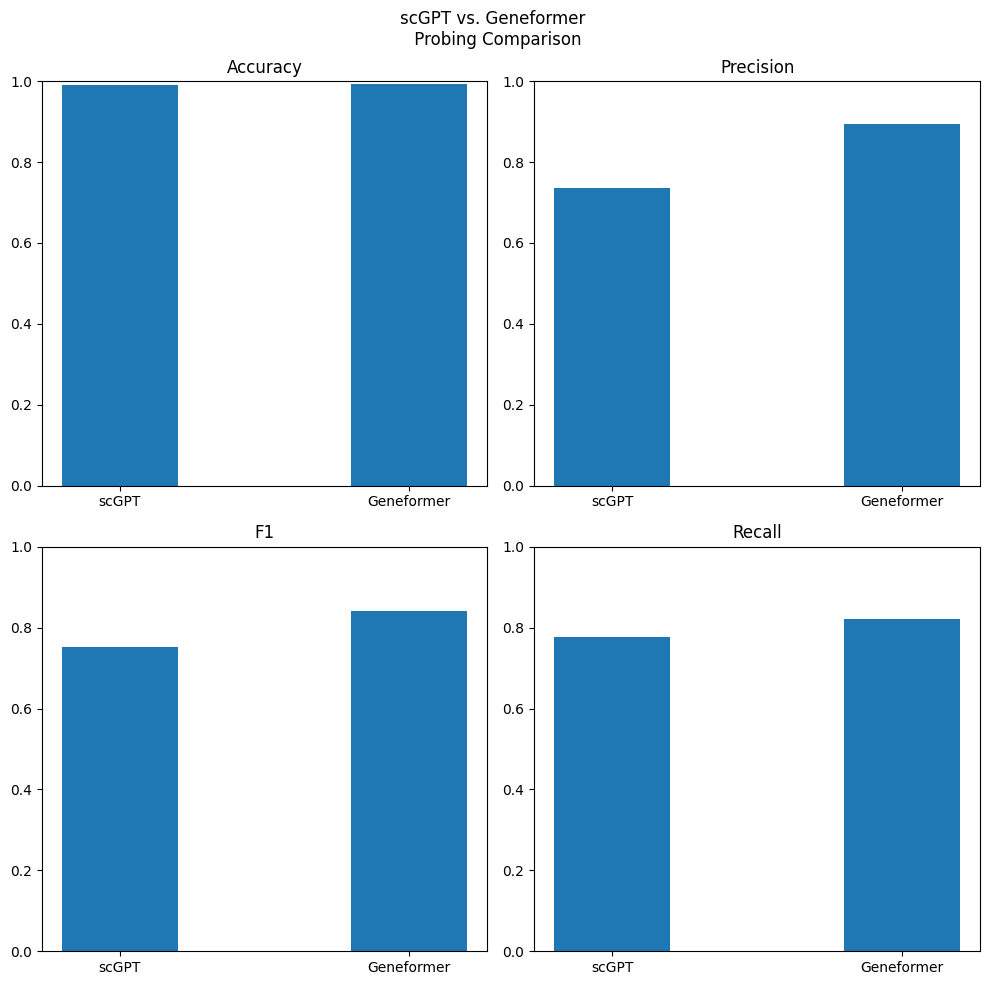

In [39]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

values_1 = [scgpt_results["accuracy"], geneformer_results["accuracy"]]
x = ["scGPT", "Geneformer"]
axs[0, 0].bar(x, values_1, width=0.4)
axs[0, 0].set_title("Accuracy")
axs[0, 0].set_ylim([0, 1])

values_2 = [scgpt_results["precision"], geneformer_results["precision"]]
axs[0, 1].bar(x, values_2, width=0.4)
axs[0, 1].set_title("Precision")
axs[0, 1].set_ylim([0, 1])

values_3 = [scgpt_results["f1"], geneformer_results["f1"]]
axs[1, 0].bar(x, values_3, width=0.4)
axs[1, 0].set_title("F1")
axs[1, 0].set_ylim([0, 1])

values_4 = [scgpt_results["recall"], geneformer_results["recall"]]
axs[1, 1].bar(x, values_4, width=0.4)
axs[1, 1].set_title("Recall")
axs[1, 1].set_ylim([0, 1])

fig.suptitle("scGPT vs. Geneformer \n Probing Comparison")
fig.tight_layout()
plt.show()



## scGPT
- Accuracy: 99.2%
- Precision: 90.8%
- Recall: 79.1%
- Macro F1: 80.7%

## Geneformer
- Accuracy: 98.9%
- Precision: 71.6%
- Recall: 73.6%
- Macro F1: 77.3%

 (c) Helical 2024 - Developed by the Helical Team